# DCGAN loss function graph

using tensorboard

Ref1 : https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

Ref2: https://arxiv.org/pdf/1511.06434.pdf

Graph_Ref3: https://www.tensorflow.org/tensorboard/get_started?hl=ko

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

**import library**

In [ ]:
from datetime import datetime
from packaging import version

In [ ]:
import tensorflow as tf
import glob
import imageio  #gif 위해
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import datetime

from IPython import display

In [ ]:
import tensorboard
tensorboard.__version__

'2.4.1'

**데이터셋 로딩**

MNIST 데이터셋 사용

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5   # 이미지 [-1, 1]로 정규화

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


**generator와 discriminator 모델 만들기**

In [ ]:
###generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
###discriminator
#CNN 기반의 이미지 분류기
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

**손실 함수 정의(첫번째 셀의 cross_entropy 사용)**

In [ ]:
#discriminator 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator 손실 함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**상태 저장 메트릭**

훈련 중에 값을 축적하는데 사용할 수 있고 언제든지 기록할 수 있다

In [ ]:
# Define our metrics
d_loss = tf.keras.metrics.Mean('d_loss', dtype=tf.float32)
g_loss = tf.keras.metrics.Mean('g_loss', dtype=tf.float32)
#d_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('discriminator_accuracy')
#g_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('generator_accuracy')

**훈련 루프 정의하기**

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    g_loss(gen_loss)
    d_loss(disc_loss)

**요약 작성기**

다른 로그 디렉토리의 디스크에 요약 작성

In [ ]:
#요약작성기
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
discriminator_log_dir = 'logs/gradient_tape/' + current_time + '/discriminator'
generator_log_dir = 'logs/gradient_tape/' + current_time + '/generator'
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)
generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            with discriminator_summary_writer.as_default():
                tf.summary.scalar('loss', d_loss.result(), step=epoch)
            with generator_summary_writer.as_default():
                tf.summary.scalar('loss', g_loss.result(), step=epoch)
        
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
                
        template = 'Epoch {}, Discriminator Loss: {}, Generator Loss: {}'
        print (template.format(epoch+1,
                         d_loss.result(), 
                         g_loss.result()))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Reset metrics every epoch
        d_loss.reset_states()
        g_loss.reset_states()

    # Generate after the final epoch
    #display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

#이미지 생성 및 저장
def generate_and_save_images(model, epoch, test_input):
    # `training`이 False로 맞춰진 것을 주목하세요.
    # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

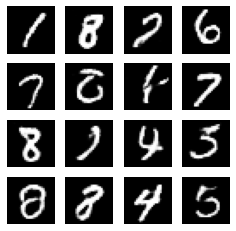

Epoch 975, Discriminator Loss: 1.2836999893188477, Generator Loss: 0.8900977373123169
Time for epoch 975 is 14.974249601364136 sec


In [ ]:
###optimizer
#generator와 discriminator는 따로 훈련→서로 optimizer 다름
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)

#checkpoint save
#오랫동안 진행되는 훈련이 방해되는 경우에 유용하게 사용가능
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#모델 훈련
train(train_dataset, EPOCHS)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
%tensorboard --logdir logs/gradient_tape

UsageError: Line magic function `%tensorboard` not found.
